In [29]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import xgboost as xgb

pd.set_option('display.max_columns', 100)

In [30]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = True

import os

In [31]:
label = 'default.payment.next.month'
train_df = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/SimpleMLP/Dataset/defaultCredit/fold0/train/data.csv')
valid_df = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/SimpleMLP/Dataset/defaultCredit/fold0/valid/data.csv')
test_df = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/SimpleMLP/Dataset/defaultCredit/fold0/test/data.csv')
train_label, valid_label, test_label = train_df[label], valid_df[label], test_df[label]
numerical_feat = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/SimpleMLP/Dataset/defaultCredit/numerical_clms.csv').columns
train_df = train_df[numerical_feat]
valid_df = valid_df[numerical_feat]
test_df = test_df[numerical_feat]
predictors = train_df.columns

In [32]:
train_df.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-0.365981,-0.812074,0.121745,0.130499,0.183809,0.275557,0.356085,0.442651,-0.341942,-0.126784,-0.126411,-0.116564,0.013131,-0.293382
1,-0.674276,-1.246020,-0.690400,-0.671425,-0.409227,-0.588044,-0.629290,-0.555651,-0.257657,0.556969,0.012684,-0.176631,0.065363,-0.119114
2,-1.136720,1.249166,-0.463971,-0.182094,-0.455414,-0.419745,-0.403667,-0.386071,-0.251378,-0.083382,-0.205927,-0.276146,-0.281409,-0.270881
3,-0.905498,0.055816,-0.049220,-0.008951,0.038614,0.091853,-0.499282,-0.484068,-0.221191,-0.161505,-0.231599,-0.276146,-0.281409,-0.272231
4,0.250611,-0.812074,-0.682442,-0.690997,-0.677943,-0.667849,-0.658140,-0.647804,-0.341942,-0.256990,-0.279762,-0.288913,-0.294893,-0.293382


In [33]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df.values, train_label.values.flatten(), feature_names=predictors)
dvalid = xgb.DMatrix(valid_df.values, valid_label.values.flatten(), feature_names=predictors)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = ['auc','aucpr']
params['random_state'] = RANDOM_STATE

In [34]:

model = xgb.train(params, 
                dtrain, 
                
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[13:04:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1660208814268/work/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.63139	train-aucpr:0.31942	valid-auc:0.61069	valid-aucpr:0.31300


/home/vineeth/anaconda3/envs/pytorch_08_2022/lib/python3.10/site-packages/xgboost/core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[50]	train-auc:0.69745	train-aucpr:0.40199	valid-auc:0.66648	valid-aucpr:0.38212
[100]	train-auc:0.71735	train-aucpr:0.42776	valid-auc:0.68073	valid-aucpr:0.40168
[150]	train-auc:0.72813	train-aucpr:0.44197	valid-auc:0.69172	valid-aucpr:0.41418
[200]	train-auc:0.73495	train-aucpr:0.45077	valid-auc:0.69607	valid-aucpr:0.42018
[250]	train-auc:0.74120	train-aucpr:0.45864	valid-auc:0.69943	valid-aucpr:0.42519
[300]	train-auc:0.74545	train-aucpr:0.46419	valid-auc:0.70306	valid-aucpr:0.42988
[350]	train-auc:0.74875	train-aucpr:0.46787	valid-auc:0.70467	valid-aucpr:0.43219
[400]	train-auc:0.75129	train-aucpr:0.47095	valid-auc:0.70577	valid-aucpr:0.43303
[450]	train-auc:0.75343	train-aucpr:0.47382	valid-auc:0.70619	valid-aucpr:0.43423
[500]	train-auc:0.75522	train-aucpr:0.47600	valid-auc:0.70598	valid-aucpr:0.43461
[550]	train-auc:0.75712	train-aucpr:0.47815	valid-auc:0.70658	valid-aucpr:0.43562
[600]	train-auc:0.75883	train-aucpr:0.48028	valid-auc:0.70647	valid-aucpr:0.43599
[650]	train-auc:0

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score, roc_auc_score
dtest = xgb.DMatrix(test_df.values, feature_names=predictors)
y_pred = model.predict(dtest)
print(classification_report(test_label.values.flatten(), np.rint(y_pred)))

print("ROC-AUC:{}".format(roc_auc_score(test_label.values.flatten(), y_pred)))
print("PrecisionRecall-AUC:{}".format(average_precision_score(test_label.values.flatten(), y_pred)))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      4660
           1       0.62      0.15      0.24      1340

    accuracy                           0.79      6000
   macro avg       0.71      0.56      0.56      6000
weighted avg       0.76      0.79      0.74      6000

ROC-AUC:0.7418683940810966
PrecisionRecall-AUC:0.45758705535278


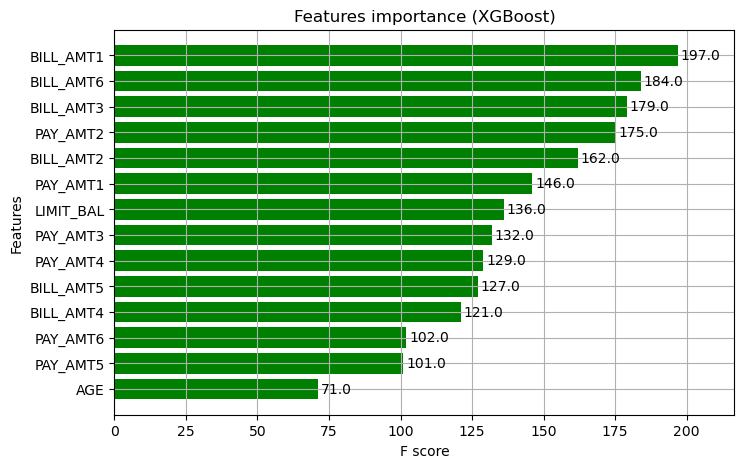

In [38]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()